In [1]:
#This notebook generates synthetic sentences to agument the RNN's training data (for BOTH of the train/test partitions and
#ALL ten sessions). Step 3 utilizes the data labels created during Step 2 to rearrange the data into new sentences. 
#The output of Step 3 is a set of .tfrecord files that are mixed together with the real data during RNN training.

In [2]:
# import tensorflow as tf

# #suppress all tensorflow warnings (largely related to compatability with v2)
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
import sklearn.decomposition 
from characterDefinitions import getHandwritingCharacterDefinitions
from makeSyntheticSentences import generateCharacterSequences, extractCharacterSnippets, addSingleLetterSnippets
import multiprocessing
import datetime
from dataPreprocessing import normalizeSentenceDataCube

#point this towards the top level dataset directory
rootDir = os.path.expanduser('~') + '/handwritingBCIData/'

#define which datasets to process
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']

#construct synthetic data for both training partitions
cvParts = ['HeldOutBlocks', 'HeldOutTrials']

#defines the list of all 31 characters and what to call them
charDef = getHandwritingCharacterDefinitions()

# #saves all synthetic sentences & snippet libraries in this folder
# if not os.path.isdir(rootDir + 'RNNTrainingSteps/Step3_SyntheticSentences'):
#     os.mkdir(rootDir + 'RNNTrainingSteps/Step3_SyntheticSentences')

In [4]:
dataDir = dataDirs[8]

In [4]:
#First, we generate snippet libraries for each dataset by cutting out each letter from each sentence. These can then
#be re-arranged into new sequences. 
for dataDir in dataDirs:
    print('Processing ' + dataDir)

    for cvPart in cvParts:
        print('--' + cvPart)

        #load datasets and train/test partition
        sentenceDat = scipy.io.loadmat('/media/rich/bigSSD/NMA_data/Willet_data/Datasets/'+dataDir+'/sentences.mat')
        singleLetterDat = scipy.io.loadmat('/media/rich/bigSSD/NMA_data/Willet_data/Datasets/'+dataDir+'/singleLetters.mat')
        twCubes = scipy.io.loadmat('/media/rich/bigSSD/NMA_data/Willet_data/Datasets/'+dataDir+'/'+dataDir+'_warpedCubes.mat')

        cvPartFile = scipy.io.loadmat('/media/rich/bigSSD/NMA_data/Willet_data/RNNTrainingSteps/'+'trainTestPartitions_'+cvPart+'.mat')
        trainPartitionIdx = cvPartFile[dataDir+'_train']

        #the last two sessions have hashmarks (#) to indicate that T5 should take a brief pause
        #here we remove these from the sentence prompts, otherwise the code below will get confused (because # isn't a character)
        for x in range(sentenceDat['sentencePrompt'].shape[0]):
            sentenceDat['sentencePrompt'][x,0][0] = sentenceDat['sentencePrompt'][x,0][0].replace('#','')

        #normalize the neural activity cube
        neuralCube = normalizeSentenceDataCube(sentenceDat, singleLetterDat)

        #load labels
        labels = scipy.io.loadmat('/media/rich/bigSSD/NMA_data/Willet_data/RNNTrainingSteps/'+'Step2_HMMLabels/'+cvPart+'/'+dataDir+'_timeSeriesLabels.mat')

        #cut out character snippets from the data for augmentation
        snippetDict = extractCharacterSnippets(labels['letterStarts'], 
                                               labels['blankWindows'], 
                                               neuralCube, 
                                               sentenceDat['sentencePrompt'][:,0], 
                                               sentenceDat['numTimeBinsPerSentence'][:,0], 
                                               trainPartitionIdx, 
                                               charDef)

        #add single letter examples
        snippetDict = addSingleLetterSnippets(snippetDict, 
                                              singleLetterDat, 
                                              twCubes, 
                                              charDef)

    #     save results
        if not os.path.isdir('/media/rich/bigSSD/NMA_data/Willet_data/Datasets/'+dataDir+'/'+cvPart+'/'):
            os.mkdir('/media/rich/bigSSD/NMA_data/Willet_data/Datasets/'+dataDir+'/'+cvPart+'/')
        scipy.io.savemat('/media/rich/bigSSD/NMA_data/Willet_data/Datasets/'+dataDir+'/'+cvPart+'/'+dataDir+'_snippets.mat', snippetDict)


Processing t5.2019.05.08
--HeldOutBlocks
--HeldOutTrials
Processing t5.2019.11.25
--HeldOutBlocks
--HeldOutTrials
Processing t5.2019.12.09
--HeldOutBlocks
--HeldOutTrials
Processing t5.2019.12.11
--HeldOutBlocks
--HeldOutTrials
Processing t5.2019.12.18
--HeldOutBlocks
--HeldOutTrials
Processing t5.2019.12.20
--HeldOutBlocks
--HeldOutTrials
Processing t5.2020.01.06
--HeldOutBlocks
--HeldOutTrials
Processing t5.2020.01.08
--HeldOutBlocks
--HeldOutTrials
Processing t5.2020.01.13
--HeldOutBlocks
--HeldOutTrials
Processing t5.2020.01.15
--HeldOutBlocks
--HeldOutTrials


In [2]:
%load_ext autoreload
%autoreload 2
from characterDefinitions import getHandwritingCharacterDefinitions
from makeSyntheticSentences import generateCharacterSequences, extractCharacterSnippets, addSingleLetterSnippets


In [3]:
#Now we use the above snippet libraries to make synthetic data for each dataset and train/test partition.

#'nParallelProcesses' specifies how many parallel processes to use when generating synthetic data (to speed things up).
#Decrease if it uses too much memory on your machine. (10 uses ~30 GB of RAM)
nParallelProcesses = 10

for dataDir in dataDirs:
    print('Processing ' + dataDir)

    for cvPart in cvParts:
        print('--' + cvPart)

        outputDir = '/media/rich/bigSSD/NMA_data/Willet_data/Datasets/'+dataDir+'/'+cvPart+'/'+dataDir+'_syntheticSentences'
        bashDir = '/media/rich/bigSSD/NMA_data/Willet_data/bashScratch'
        repoDir = os.getcwd()

        if not os.path.isdir(outputDir):
            os.mkdir(outputDir)

        if not os.path.isdir(bashDir):
            os.mkdir(bashDir)

        args = {}
        args['nSentences'] = 256
        args['nSteps'] = 2400
        args['binSize'] = 2
        args['wordListFile'] = repoDir+'/wordList/google-10000-english-usa.txt' #from https://github.com/first20hours/google-10000-english
        args['rareWordFile'] = repoDir+'/wordList/rareWordIdx.mat'
        args['snippetFile'] = '/media/rich/bigSSD/NMA_data/Willet_data/Datasets/'+dataDir+'/'+cvPart+'/'+dataDir+'_snippets.mat'
        args['accountForPenState'] = 1
        args['charDef'] = getHandwritingCharacterDefinitions()
        args['seed'] = datetime.datetime.now().microsecond

        argList = []
        for x in range(20):
            newArgs = args.copy()
            newArgs['saveFile'] = outputDir+'/bat_'+str(x)+'.tfrecord'
            newArgs['seed'] += x
            argList.append(newArgs)

    #     generateCharacterSequences(args)
        pool = multiprocessing.Pool(nParallelProcesses)     
        results = pool.map(generateCharacterSequences, argList)

        pool.close()
        pool.join()


Processing t5.2019.05.08
--HeldOutBlocks
--HeldOutTrials
Processing t5.2019.11.25
--HeldOutBlocks
--HeldOutTrials
Processing t5.2019.12.09
--HeldOutBlocks
--HeldOutTrials
Processing t5.2019.12.11
--HeldOutBlocks
--HeldOutTrials
Processing t5.2019.12.18
--HeldOutBlocks
--HeldOutTrials
Processing t5.2019.12.20
--HeldOutBlocks
--HeldOutTrials
Processing t5.2020.01.06
--HeldOutBlocks
--HeldOutTrials
Processing t5.2020.01.08
--HeldOutBlocks
--HeldOutTrials
Processing t5.2020.01.13
--HeldOutBlocks
--HeldOutTrials
Processing t5.2020.01.15
--HeldOutBlocks
--HeldOutTrials


In [15]:
import sys
results[0][0].shape

(256, 1200, 32)

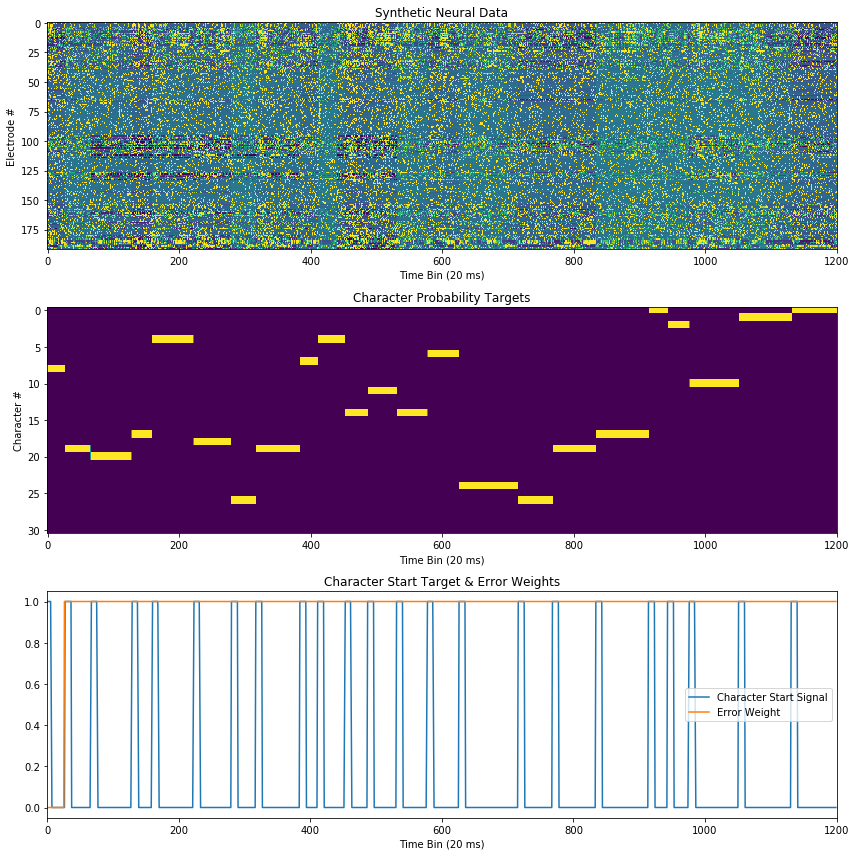

In [11]:
#plot an example synthetic sentence
trlIdx = 22

plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.imshow(np.transpose(results[0][0][trlIdx,:,:]),aspect='auto',clim=[-1,1])
plt.title('Synthetic Neural Data')
plt.ylabel('Electrode #')
plt.xlabel('Time Bin (20 ms)')

plt.subplot(3,1,2)
plt.imshow(np.transpose(results[0][1][trlIdx,:,0:-1]),aspect='auto')
plt.title('Character Probability Targets')
plt.ylabel('Character #')
plt.xlabel('Time Bin (20 ms)')

plt.subplot(3,1,3)
plt.plot(results[0][1][trlIdx,:,-1])
plt.plot(results[0][2][trlIdx,:])
plt.xlim([0,results[0][1].shape[1]])
plt.title('Character Start Target & Error Weights')
plt.legend(['Character Start Signal', 'Error Weight'])
plt.xlabel('Time Bin (20 ms)')

plt.tight_layout()
plt.show()

In [42]:
sys.executable

'/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/bin/python'

In [1]:
# import sys
# sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
# %load_ext autoreload
# %autoreload 2


In [47]:
import torch
from pathlib import Path
from tfrecord.torch.dataset import TFRecordDataset

dir_load = Path(r'/media/rich/bigSSD/NMA_data/Willet_data/Datasets/t5.2020.01.08/HeldOutTrials/t5.2020.01.08_syntheticSentences').resolve()
# dir_load = Path(r'/media/rich/bigSSD/NMA_data/Willet_data/Datasets/t5.2020.01.08/HeldOutBlocks/t5.2020.01.08_syntheticSentences').resolve()
tfrecord_path = dir_load / r'bat_0.tfrecord'
index_path = None
description = {"image": "byte", "label": "float"}
dataset = TFRecordDataset(tfrecord_path,
                          index_path,
#                           description
                         )
loader = torch.utils.data.DataLoader(dataset, batch_size=32)

data = next(iter(loader))
print(data)

{'errWeights': tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]]), 'labels': tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]]), 'inputs': tensor([[ 0.7186, -0.2645, -0.2532,  ...,  1.2587, -0.3302, -0.0777],
        [-0.5623,  2.9737, -0.5344,  ..., -0.3432, -0.2501, -0.0588],
        [-0.3353, -0.3546, -0.3395,  ...,  0.1099, -0.3303,  0.6036],
        ...,
        [ 0.8484, -0.3123, -0.2990,  ..., -0.3701, -0.2604, -0.2089],
        [-0.3001, -0.3174,  0.8478,  ...,  1.3576, -0.3562, -0.0838],
        [ 0.8040, -0.2959, -0.2833,  ...,  1.0974, -0.2879, -0.0677]])}


In [56]:
del data_rs

In [60]:
data['inputs'].shape
data_rs = {}
data_rs['inputs'] = data['inputs'].reshape((32, int(data['inputs'].shape[1]/192), 192))
data_rs['labels'] = data['labels'].reshape((32, int(data['labels'].shape[1]/192), 192))

In [44]:
data.keys()

dict_keys(['inputs', 'errWeights', 'labels'])

In [16]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


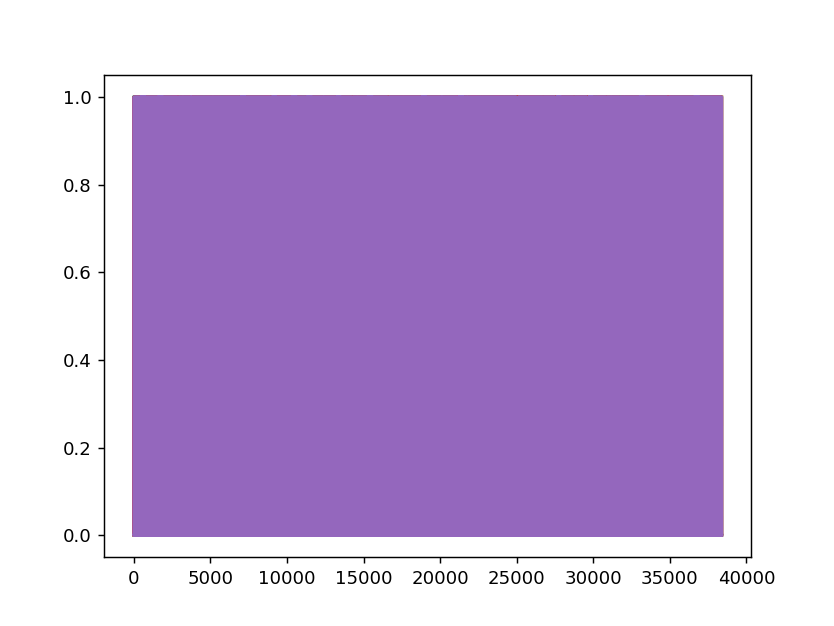

In [33]:
%matplotlib notebook
plt.figure()
plt.plot(data['labels'][0:5].T)

In [24]:
import numpy as np

In [31]:
np.std(data['inputs'][0].numpy())

0.74489766

<IPython.core.display.Javascript object>


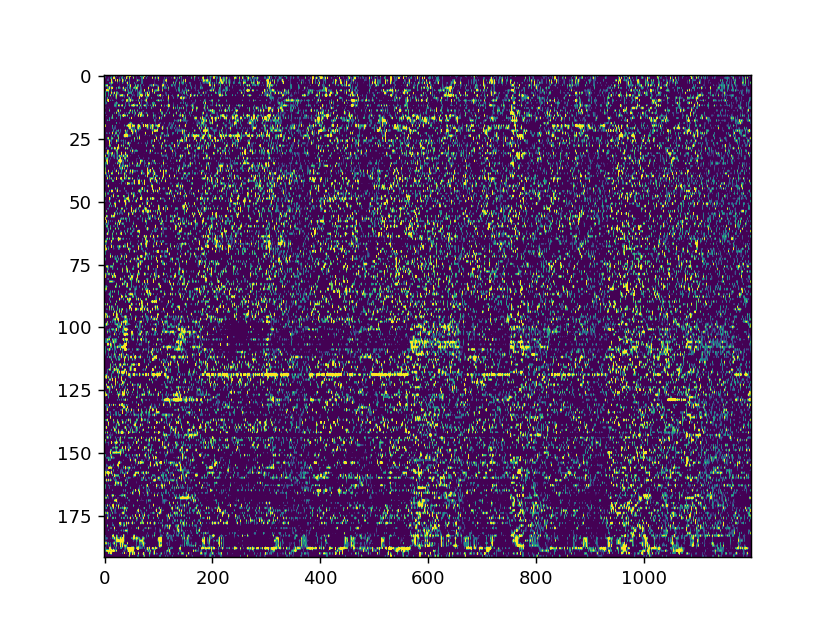

<IPython.core.display.Javascript object>


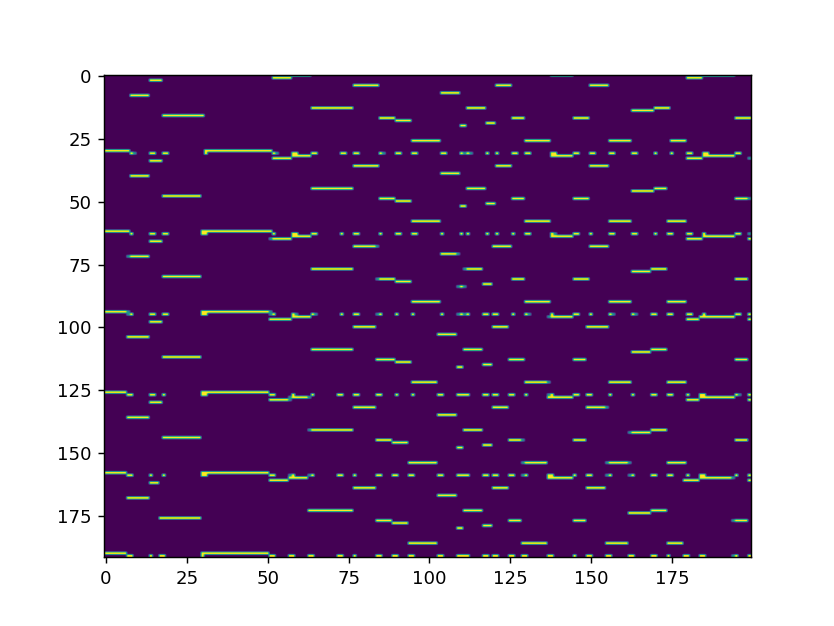

In [65]:
plt.figure()
plt.imshow(data_rs['inputs'][1].T,
          aspect='auto',
#           interpolation='none',
           clim=(0,1)
          )
plt.figure()
plt.imshow(data_rs['labels'][1].T,
          aspect='auto',
#           interpolation='none',
           clim=(0,1)
          )

In [64]:
data['inputs'].shape

torch.Size([32, 230400])